In [15]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import sys
from os import path
sys.path.insert(0, "../ISANet/")
sys.path.insert(0, "./")

from isanet.model import Mlp
from isanet.optimizer import SGD, NCG, LBFGS
from isanet.optimizer.utils import l_norm
from isanet.datasets.monk import load_monk
from isanet.utils.model_utils import printMSE, printAcc, plotHistory
import isanet.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def get_fitted_model(X_train, Y_train, optimizer, n_seed = 189, verbose = 1):
    np.random.seed(seed=n_seed)
    print("Build the model")
    reg = 1e-4
    model = Mlp()
    model.add(4, input= 17, kernel_initializer = 0.003, kernel_regularizer = reg)
    model.add(1, kernel_initializer = 0.003, kernel_regularizer = reg)

    print("norm_w0: {}".format(l_norm(model.weights)))
    print("sum_w0: {}".format([np.sum(np.square(x)) for x in model.weights]))
    model.set_optimizer(optimizer)
    out = model.predict(X_train)
    print("f: {}".format(metrics.mse(Y_train, out)))
    start = time.time()
    model.fit(X_train,
            Y_train, 
            epochs=20000, 
            verbose=verbose)
    end = time.time()
    return model, (end - start)

def ls_stat(info):
    converged = 0
    tot_iteration = 0
    tot = len(info["ls_conv"])
    for i in range(tot):
        tot_iteration += info["ls_it"][i] + info["zoom_it"][i]
        if info["ls_conv"][i] == "y":
            converged += 1
    
    print("Ls Hit Rate: {}".format(converged/tot))
    print("Ls iteration: {}".format(tot_iteration))

# MONK 1

In [17]:
print("Load Monk DataSet")
X_train, Y_train = load_monk("1", "train")

seed =   108 #108
results = []
eps = 1e-5

Load Monk DataSet


In [18]:
#############################
#     NCG f1 - no restart
#############################
restart = None
optimizer = NCG(beta_method="fr", c1=1e-4, c2=.1, restart=restart, ln_maxiter = 100, norm_g_eps = eps, l_eps = eps)

model, t = get_fitted_model(X_train, Y_train, optimizer, seed, 2)
print("Time: {}".format(t))
print("Ls Time: {}".format(np.sum(optimizer.history["ls_time"])))
ls_stat(optimizer.history)
h_fr_no_restart = model.history
results.append(h_fr_no_restart["loss_mse_reg"][-1]) 

Build the model
norm_w0: 0.015421459306491195
sum_w0: [0.00021072665495907032, 2.709475218269356e-05]
f: 0.24999994423671887
| beta: 0 | alpha: 5.566274812341263 | ng: 0.00027196969334937796 | ls conv: y, it: 3, time: 0.0039 | zoom used: y, conv: y, it: 0|
Epoch: 1 - time: 0.0081 - loss_train: 0.24999976215715983 - loss_val: 0
| beta: 0.4240933461156956 | alpha: 34270.22638433325 | ng: 0.00017711332688074075 | ls conv: y, it: 16, time: 0.0189 | zoom used: y, conv: y, it: 1|
Epoch: 2 - time: 0.0205 - loss_train: 0.1581769191129326 - loss_val: 0
| beta: 59363.9440590709 | alpha: 0.0029305553496197373 | ng: 0.043153161085512204 | ls conv: y, it: 0, time: 0.0093 | zoom used: y, conv: y, it: 6|
Epoch: 3 - time: 0.0114 - loss_train: 0.1581744488277414 - loss_val: 0
| beta: 0.9931657620011153 | alpha: 0.0032388040820831546 | ng: 0.04300544879095892 | ls conv: y, it: 0, time: 0.0027 | zoom used: y, conv: y, it: 5|
Epoch: 4 - time: 0.0041 - loss_train: 0.15817164443994147 - loss_val: 0
| beta: 

In [20]:
#############################
#     NCG f1 - 15 restart
#############################
restart = 15
optimizer = NCG(beta_method="fr", c1=1e-4, c2=.1, restart=restart, ln_maxiter = 100, norm_g_eps = eps, l_eps = eps)

model, t = get_fitted_model(X_train, Y_train, optimizer, seed, 2)
print("Time: {}".format(t))
print("Ls Time: {}".format(np.sum(optimizer.history["ls_time"])))
ls_stat(optimizer.history)

h_fr_r_15 = model.history
results.append(h_fr_r_15["loss_mse"]) 

Build the model
norm_w0: 0.015421459306491195
sum_w0: [0.00021072665495907032, 2.709475218269356e-05]
f: 0.24999994423671887
| beta: 0 | alpha: 5.566274812341263 | ng: 0.00027196969334937796 | ls conv: y, it: 3, time: 0.0040 | zoom used: y, conv: y, it: 0|
Epoch: 1 - time: 0.0068 - loss_train: 0.24999976215715983 - loss_val: 0
| beta: 0.4240933461156956 | alpha: 34270.22638433325 | ng: 0.00017711332688074075 | ls conv: y, it: 16, time: 0.0212 | zoom used: y, conv: y, it: 1|
Epoch: 2 - time: 0.0227 - loss_train: 0.1581769191129326 - loss_val: 0
| beta: 59363.9440590709 | alpha: 0.0029305553496197373 | ng: 0.043153161085512204 | ls conv: y, it: 0, time: 0.0029 | zoom used: y, conv: y, it: 6|
Epoch: 3 - time: 0.0044 - loss_train: 0.1581744488277414 - loss_val: 0
| beta: 0.9931657620011153 | alpha: 0.0032388040820831546 | ng: 0.04300544879095892 | ls conv: y, it: 0, time: 0.0027 | zoom used: y, conv: y, it: 5|
Epoch: 4 - time: 0.0049 - loss_train: 0.15817164443994147 - loss_val: 0
| beta: 

In [21]:
#############################
#     NCG f1 - 3 restart
#############################
restart = 3
optimizer = NCG(beta_method="fr", c1=1e-4, c2=.1, restart=restart, ln_maxiter = 100, norm_g_eps = eps, l_eps = eps)

model, t = get_fitted_model(X_train, Y_train, optimizer, seed, 2)
print("Time: {}".format(t))
print("Ls Time: {}".format(np.sum(optimizer.history["ls_time"])))
ls_stat(optimizer.history)
h_fr_r_3 = model.history
results.append(h_fr_r_3["loss_mse"]) 

Build the model
norm_w0: 0.015421459306491195
sum_w0: [0.00021072665495907032, 2.709475218269356e-05]
f: 0.24999994423671887
| beta: 0 | alpha: 5.566274812341263 | ng: 0.00027196969334937796 | ls conv: y, it: 3, time: 0.0022 | zoom used: y, conv: y, it: 0|
Epoch: 1 - time: 0.0049 - loss_train: 0.24999976215715983 - loss_val: 0
| beta: 0.4240933461156956 | alpha: 34270.22638433325 | ng: 0.00017711332688074075 | ls conv: y, it: 16, time: 0.0226 | zoom used: y, conv: y, it: 1|
Epoch: 2 - time: 0.0250 - loss_train: 0.1581769191129326 - loss_val: 0
| beta: 59363.9440590709 | alpha: 0.0029305553496197373 | ng: 0.043153161085512204 | ls conv: y, it: 0, time: 0.0040 | zoom used: y, conv: y, it: 6|
Epoch: 3 - time: 0.0062 - loss_train: 0.1581744488277414 - loss_val: 0
| beta: 0 | alpha: 4.429920442727077 | ng: 0.04300544879095892 | ls conv: y, it: 3, time: 0.0074 | zoom used: y, conv: y, it: 0|
Epoch: 4 - time: 0.0086 - loss_train: 0.15402026657431506 - loss_val: 0
| beta: 0.4209799926961299 | 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


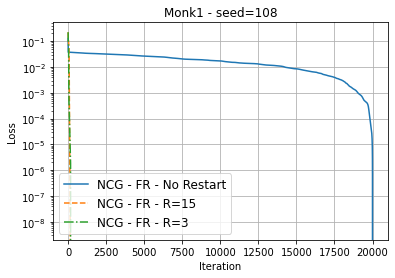

In [22]:
pos_train = (0,0)
figsize = (12, 4)

plt.plot(h_fr_no_restart["loss_mse_reg"] - h_fr_no_restart["loss_mse_reg"][-1], linestyle='-')
plt.plot(h_fr_r_15["loss_mse_reg"] - h_fr_r_15["loss_mse_reg"][-1], linestyle = '--')
plt.plot(h_fr_r_3["loss_mse_reg"] - h_fr_r_3["loss_mse_reg"][-1], linestyle='-.')
plt.title('Monk1 - seed={}'.format(seed))
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.grid()
plt.yscale('log')
plt.legend(['NCG - FR - No Restart','NCG - FR - R={}'.format(15),'NCG - FR - R={}'.format(3)], loc='lower left', fontsize='large')
plt.savefig('./plot/monk1_fr.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


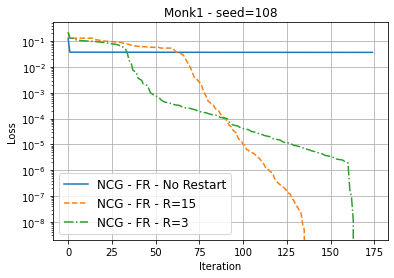

In [28]:
pos_train = (0,0)
figsize = (12, 4)
zoom = 175
plt.plot(h_fr_no_restart["loss_mse_reg"][:zoom] - h_fr_no_restart["loss_mse_reg"][-1], linestyle='-')
plt.plot(h_fr_r_15["loss_mse_reg"][:zoom] - h_fr_r_15["loss_mse_reg"][-1], linestyle = '--')
plt.plot(h_fr_r_3["loss_mse_reg"][:zoom] - h_fr_r_3["loss_mse_reg"][-1], linestyle='-.')
plt.title('Monk1 - seed={}'.format(seed))
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.grid()
plt.yscale('log')
plt.legend(['NCG - FR - No Restart','NCG - FR - R={}'.format(15),'NCG - FR - R={}'.format(3)], loc='lower left', fontsize='large')
plt.savefig('./plot/monk1_fr_zoomed.eps', format='eps')
plt.show()